In [89]:
from road_risk_model.generate_map_graph import *
from data.synthetic_road_datasets import *
from road_risk_model.model import *
from classic_pricing_model.behavioral_risk_modeler import *

# Generate Data

## Generate Graph of Chengdu's Map

In [71]:
G = generate_map_graph()

/Users/aryanahri/Desktop/chengdu_full_model/road_risk_model/generate_map_graph.py:20: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(
/Users/aryanahri/Desktop/chengdu_full_model/road_risk_model/generate_map_graph.py:20: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(


## Find Shortest and Start/End Nodes from Coordinates

In [72]:
shortest_route, start_node, end_node = find_shortest_route(G)

## Create Synthetic Data to Train Road Risk Model

In [73]:
sample_data, wait_times, severities = create_synth_data(G, start_node, end_node)

# Road Risk Model (on Synthetic Data)

## Train the Model

In [74]:
 # ----------------- Create and Fit the Model -----------------


model = RoadRiskModel(validation_fraction=0.1)
metrics = model.fit(sample_data.drop(
    columns=['u', 'v']), wait_times, severities)


/Users/aryanahri/anaconda3/envs/math4210/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/aryanahri/anaconda3/envs/math4210/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Generate Risk Scores for Each Road

In [75]:
# ----------------- Get Predictions and Map to (u, v) Tuples -----------------

predictions = model.predict_risk(sample_data.drop(columns=['u', 'v']))

# Create a dictionary mapping (u, v) to risk_score
risk_dict = {}
for i, pred in enumerate(predictions):
    u = sample_data.iloc[i]['u']
    v = sample_data.iloc[i]['v']
    risk_score = pred.risk_score
    risk_dict[(u, v)] = risk_score

# ----------------- Output the Risk Dictionary -----------------

print("Risk scores for each edge (u, v):")
for edge, score in list(risk_dict.items())[:10]:  # Print first 10 for brevity
    print(f"Edge {edge}: Risk Score = {score:.3f}")

Risk scores for each edge (u, v):
Edge (276556859.0, 1492609349.0): Risk Score = 0.020
Edge (276556859.0, 9243379223.0): Risk Score = 0.018
Edge (276556860.0, 7618649237.0): Risk Score = 0.024
Edge (276556885.0, 1493185884.0): Risk Score = 0.023
Edge (276556885.0, 671581609.0): Risk Score = 0.018
Edge (276556900.0, 3651253754.0): Risk Score = 0.016
Edge (276556900.0, 3043348612.0): Risk Score = 0.019
Edge (276556906.0, 4547050472.0): Risk Score = 0.019
Edge (276556906.0, 11693698921.0): Risk Score = 0.021
Edge (276557064.0, 4547050411.0): Risk Score = 0.021


## Assign the Scores to the Corresponding Roads

In [76]:
# Iterate over all edges in the graph with their data
for u, v, key, data in G.edges(keys=True, data=True):
    edge_tuple = (u, v)
    # Check if the edge is in the risk_dict
    if edge_tuple in risk_dict:
        data['risk'] = risk_dict[edge_tuple]
    # If the graph is undirected or you want to consider reverse edges
    elif (v, u) in risk_dict:
        data['risk'] = risk_dict[(v, u)]

# Compute the Safest Path (Pathfinding)

In [77]:
import networkx as nx

Unlike before, we are now penalizing the pathfinding algorithm (Dijkstra's) on our computed _risk scores_ for the roads. Notice the difference in the paths.

In [78]:
safest_route = nx.shortest_path(G, start_node, end_node, weight='risk')

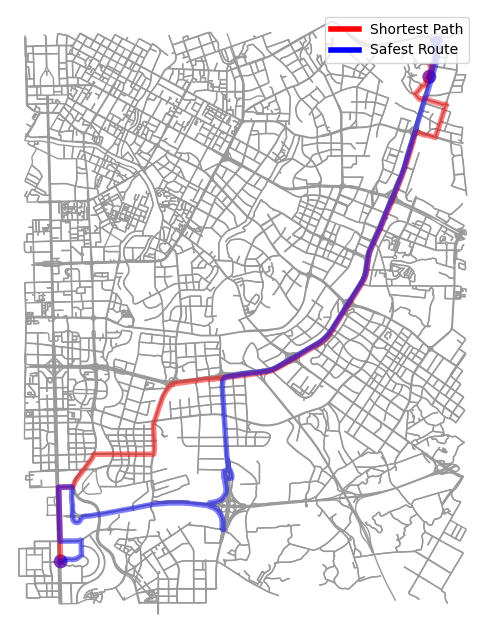

In [79]:
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Plot the graph and the routes
fig, ax = ox.plot_graph_routes(
    G,
    routes=[shortest_route, safest_route],
    route_colors=['red', 'blue'],      # Colors for the routes
    route_linewidth=4,                 # Line width for the routes
    node_size=0,                       # Node size (0 to hide nodes)
    bgcolor='white',                   # Background color
    show=False,                        # Do not display immediately
    close=False                        # Do not close the figure
)

# Create custom legend handles
red_line = mlines.Line2D([], [], color='red', linewidth=4, label='Shortest Path')
blue_line = mlines.Line2D([], [], color='blue', linewidth=4, label='Safest Route')

# Add the legend to the plot
ax.legend(handles=[red_line, blue_line], loc='upper right')

# Display the plot
plt.show()

# Classic Pricing Model

                 Generalized Linear Model Regression Results                  
Dep. Variable:     total_claim_amount   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7945
Model Family:                   Gamma   Df Model:                           54
Link Function:                    Log   Scale:                        0.078026
Method:                          IRLS   Log-Likelihood:                -75007.
Date:                Tue, 29 Oct 2024   Deviance:                       611.57
Time:                        03:52:03   Pearson chi2:                     620.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.8197
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

/Users/aryanahri/Desktop/chengdu_full_model/classic_pricing_model/behavioral_risk_modeler.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_sev.head(10),


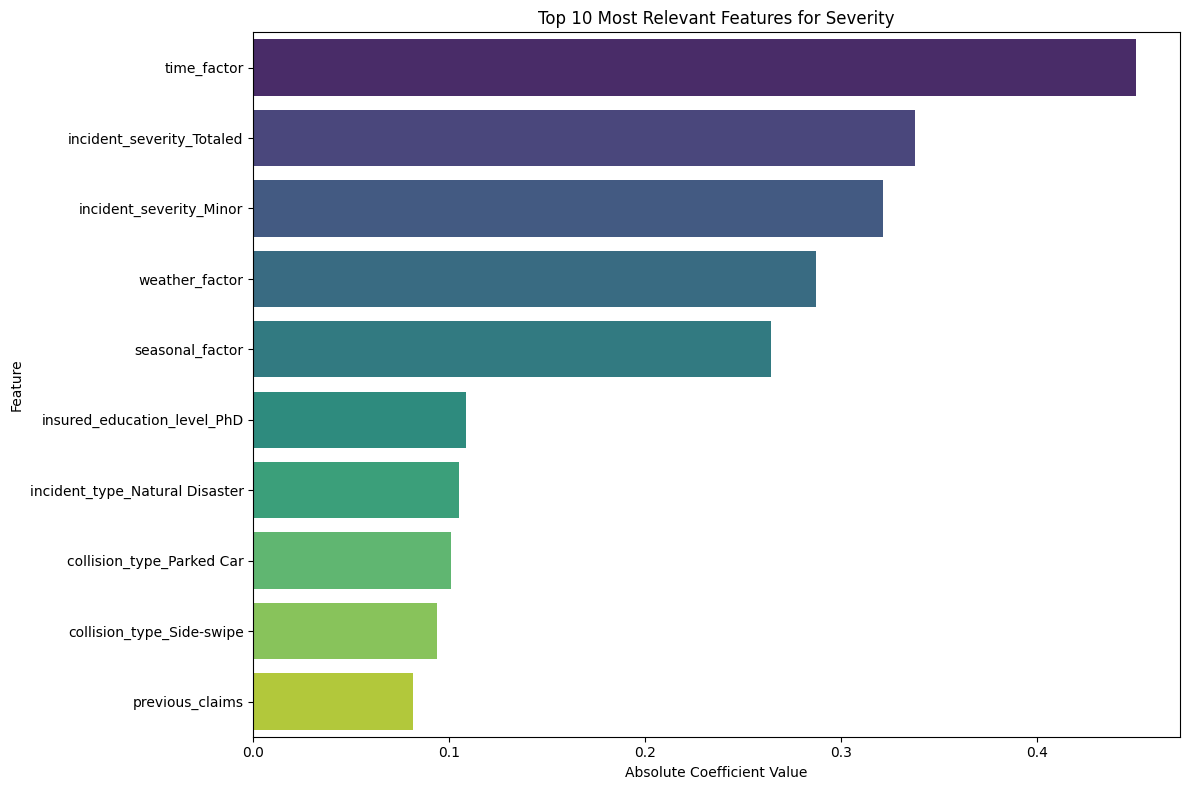

                 Generalized Linear Model Regression Results                  
Dep. Variable:              frequency   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7945
Model Family:                 Poisson   Df Model:                           54
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9544.0
Date:                Tue, 29 Oct 2024   Deviance:                       8045.9
Time:                        03:52:04   Pearson chi2:                 8.09e+03
No. Iterations:                   100   Pseudo R-squ. (CS):             0.6334
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

/Users/aryanahri/Desktop/chengdu_full_model/classic_pricing_model/behavioral_risk_modeler.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_freq.head(10),


NameError: name 'output_dir' is not defined

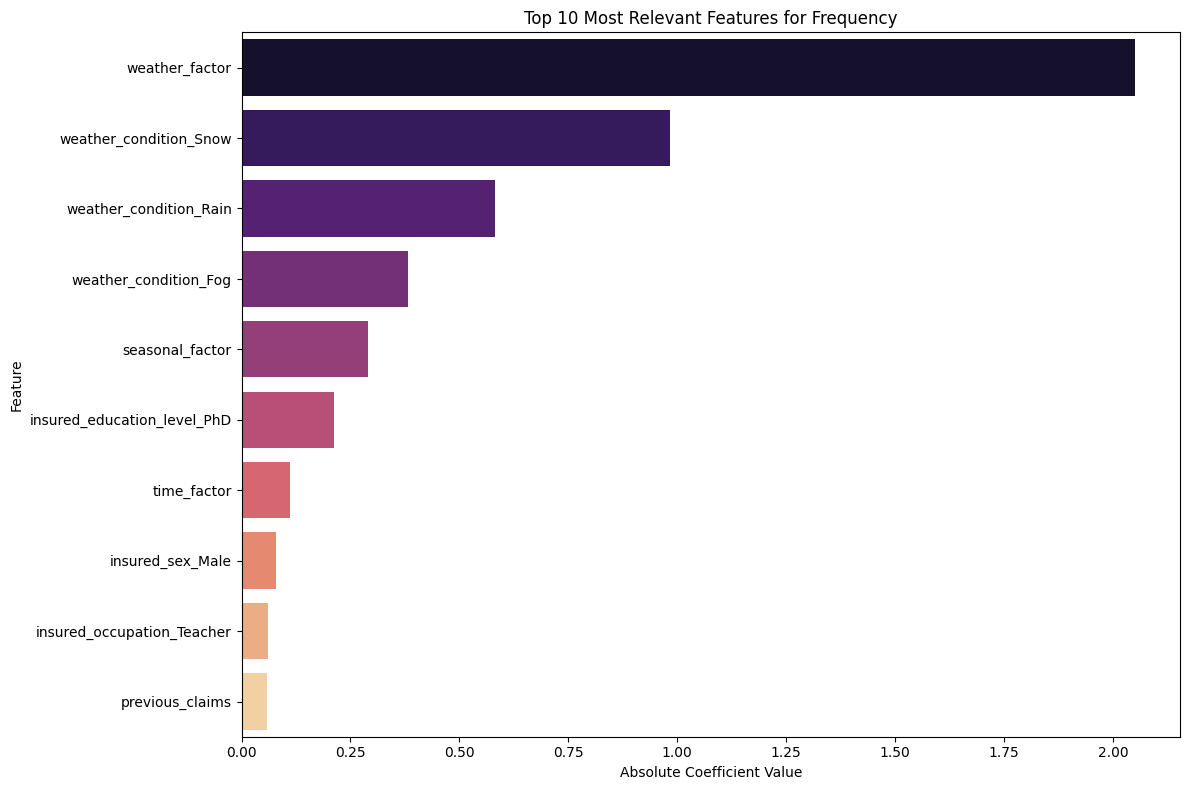

In [90]:
run_classic_price_model()

# IoT Model

See the `iot_model.ipynb` file to observe our preliminary method to incorporate IoT data into our framework. Ultimately, we did not want to allocate time away from other aspects of our model to focus on this, so it is not fully integrated.